In [1]:
import torch as t
from scipy import ndimage
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
#device = t.device('cuda' if t.cuda.is_available() else 'cpu')
device = t.device('cpu')

In [3]:
MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (0, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)
def get_moore_nbh(batch:t.Tensor):
    batch_size, batch_height, batch_width = batch.shape
    cell_pixel_coords = (batch == 1).nonzero()
    nbh_coords = (cell_pixel_coords[:, 1:].unsqueeze(1)+MOORE_OFFSETS.type(t.float).unsqueeze(0))
    idx_pad = cell_pixel_coords[:, 0].repeat(9,1).T.reshape(cell_pixel_coords[:, 0].shape[0], 9, 1)
    nbh_coords[nbh_coords == -1] = 1
    nbh_coords[nbh_coords == batch_height] = batch_height -2
    return t.concatenate((idx_pad, nbh_coords), dim=-1)

In [4]:
STEP_SIZES = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)

def MCS(batch, target_vol, temperature):
    batch_size, batch_height, batch_width = batch.shape
    frontiers = get_moore_nbh(batch)
    
    src_coords = []
    for batch_idx in range(batch_size):
        frontier = frontiers[frontiers[:, :, 0] == batch_idx, :].unique(dim=0)
        src_coords.append(random.choice(frontier).type(t.long))
    batch_src_coords = t.vstack(src_coords)
    step_sizes = t.vstack(random.choices(STEP_SIZES, k=batch_src_coords.shape[0]))
    tgt_coords = t.hstack((batch_src_coords[:, 0].unsqueeze(0).T, batch_src_coords[:, 1:] + step_sizes))
    tgt_coords[:, 1:][tgt_coords[:, 1:] == -1] = 1
    tgt_coords[:, 1:][tgt_coords[:, 1:] == batch_height] = batch_height -2
    tgt_i = tgt_coords[:, 0]
    tgt_j = tgt_coords[:, 1]
    tgt_k = tgt_coords[:, 2]
    src_i = batch_src_coords[:, 0]
    src_j = batch_src_coords[:, 1]
    src_k = batch_src_coords[:, 2]
    
    #print(src_i, src_j, src_k)
    #print(tgt_i, tgt_j, tgt_k)
    
    current_volumes = t.sum(batch, dim=(-1, -2))
    vol_changes = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
    adjusted_vols = current_volumes + vol_changes
    
    #print(current_volumes)
    #print(vol_changes)
    #print(adjusted_vols)
    
    unequal_mask = batch[tgt_i, tgt_j, tgt_k] != batch[src_i, src_j, src_k]
    sml_eq_two_mask = adjusted_vols <= 2
    greater_zero_mask = adjusted_vols > 0
    vol_change_positive_mask = vol_changes > 0
    vol_change_negative_mask = vol_changes < 0
    
    auto_upd_mask = t.logical_and(
        vol_change_negative_mask,
        greater_zero_mask
    )
    
    #print(auto_upd_mask)
    
    auto_upd_i = tgt_i[auto_upd_mask]
    auto_upd_j = tgt_j[auto_upd_mask]
    auto_upd_k = tgt_k[auto_upd_mask]
    
    batch[auto_upd_i, auto_upd_j, auto_upd_k] += vol_changes[auto_upd_mask]
    
     
    update_mask = t.logical_and(
        vol_change_positive_mask,
        t.logical_and(
            greater_zero_mask,
            t.logical_and(unequal_mask, sml_eq_two_mask)
        )
    )
    
    #print(update_mask)
    
    #print(vol_changes[update_mask])
    #print(adjusted_vols[update_mask])
    #print(f"delta h {-((target_vol - adjusted_vols[update_mask]) ** 2)}")
    update_probabilities = t.exp(-((target_vol - adjusted_vols[update_mask]) ** 2) / temperature)
    #print(f"prob: {update_probabilities}")
    logits = t.cat((update_probabilities.unsqueeze(0), (1-update_probabilities).unsqueeze(0))).T
    #print(f"logits: {logits}")
    one_hot = t.nn.functional.gumbel_softmax(t.log(logits), hard=True)
    #print(one_hot)
    upd_vals = one_hot[:,0] * vol_changes[update_mask]
    
    upd_i = tgt_i[update_mask]
    upd_j = tgt_j[update_mask]
    upd_k = tgt_k[update_mask]
    
    #print(upd_i, upd_j, upd_k)
    
    batch[upd_i, upd_j, upd_k] += upd_vals.squeeze()
    
    return batch
    

In [5]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float, num_steps:int):
    for i in tqdm(range(num_steps)):
        batch = MCS(batch, target_vol, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    print(f"temperature: {temperature}, mean distance: {mean_distance}")
    grad = t.autograd.grad(mean_distance, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, mean_distance

In [6]:
def create_dist_matrix(batch:t.Tensor):
    dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-batch[0].cpu(), return_indices=False)
    dist_matrix = dist_matrix**2
    dist_matrix_t = t.from_numpy(dist_matrix).to(device)
    return dist_matrix_t

# Visualize sample sim

In [7]:
temperature = 27.
target_vol = 1.
batch = t.zeros(1,8,8, device=device)
batch[:,4,4] += 1

states = []
for i in tqdm(range(10000)):
    batch = MCS(batch, target_vol, temperature)
    if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
        print("ISSUE DETECTED, STOP SIM")
        break
    else:
        states.append(batch[0].detach().clone().cpu().numpy())

imgs = [Image.fromarray((1-state)*255) for state in states]
print(len(imgs))
imgs[0].save("test.gif", save_all=True, append_images=imgs[1:], fps=60)

100%|██████████| 10000/10000 [00:16<00:00, 623.20it/s]


10000


# Num_steps = 40, 8x8 grid

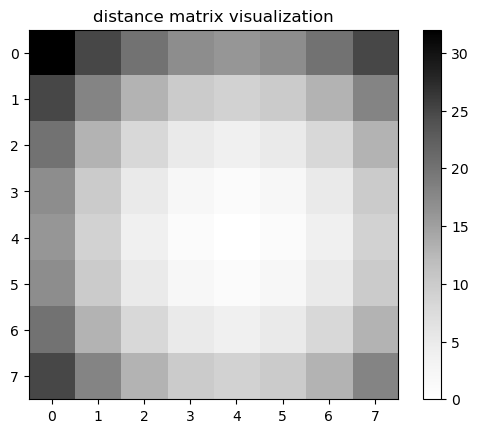

In [8]:
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
fig = plt.imshow(dist_matrix.numpy(), cmap="Greys", interpolation="nearest", vmin=0, vmax=np.max(dist_matrix.numpy()))
plt.colorbar(fig)
plt.title("distance matrix visualization")
plt.show()

target_vol = 0, 8x8 grid

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)

grads_v0 = []
mean_distances_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())

target_vol = 1, 8x8 grid

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)

grads_v1 = []
mean_distances_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())

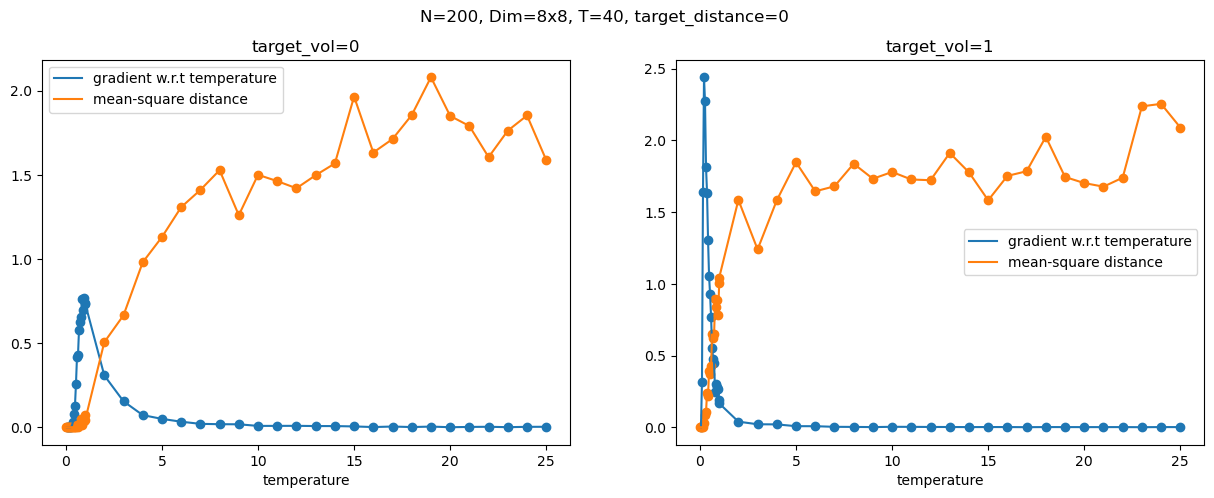

In [11]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].set(title="target_vol=1", xlabel="temperature")
axs[1].legend()

fig.suptitle("N=200, Dim=8x8, T=40, target_distance=0")
plt.show()


# Introduce Squared loss to target distance

In [12]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float, num_steps:int, target_distance:float):
    for i in tqdm(range(num_steps)):
        batch = MCS(batch, target_vol, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    print(f"temperature: {temperature}, mean distance: {mean_distance}")
    loss = (mean_distance - target_distance)**2
    grad = t.autograd.grad(loss, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, mean_distance, loss

## Num_steps = 40, 8x8 grid

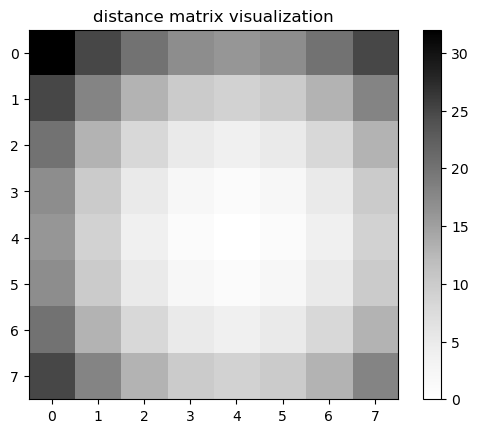

In [13]:
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
fig = plt.imshow(dist_matrix.numpy(), cmap="Greys", interpolation="nearest", vmin=0, vmax=np.max(dist_matrix.numpy()))
plt.colorbar(fig)
plt.title("distance matrix visualization")
plt.show()

target_vol = 0, target_dist = 0

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

target_vol = 1, target_dist = 0

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

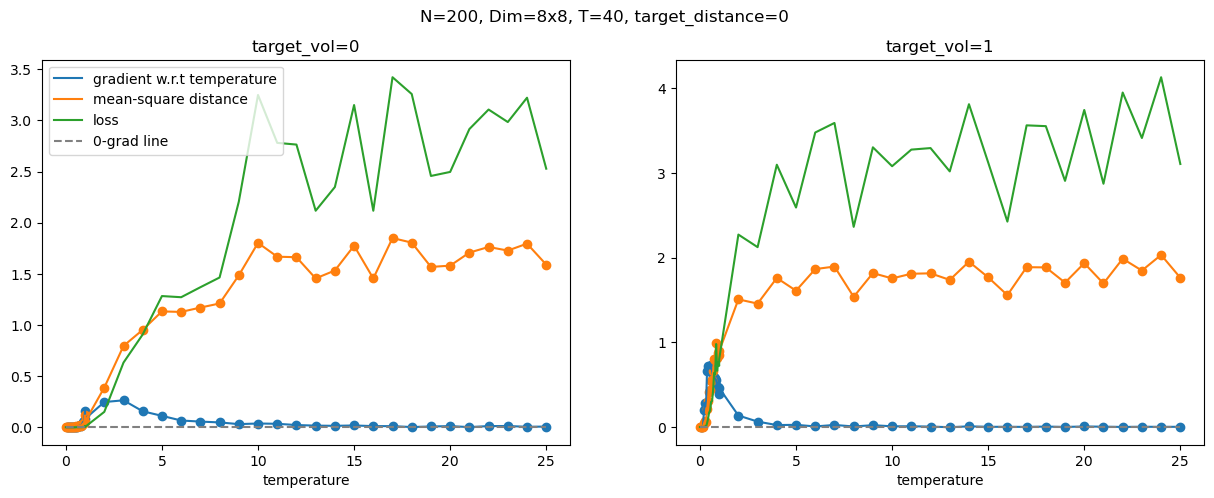

In [16]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=200, Dim=8x8, T=40, target_distance=0")
plt.show()


target_vol = 0, target_dist = 0.2

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.2

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

target_vol = 1, target_dist = 0.2

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.2

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

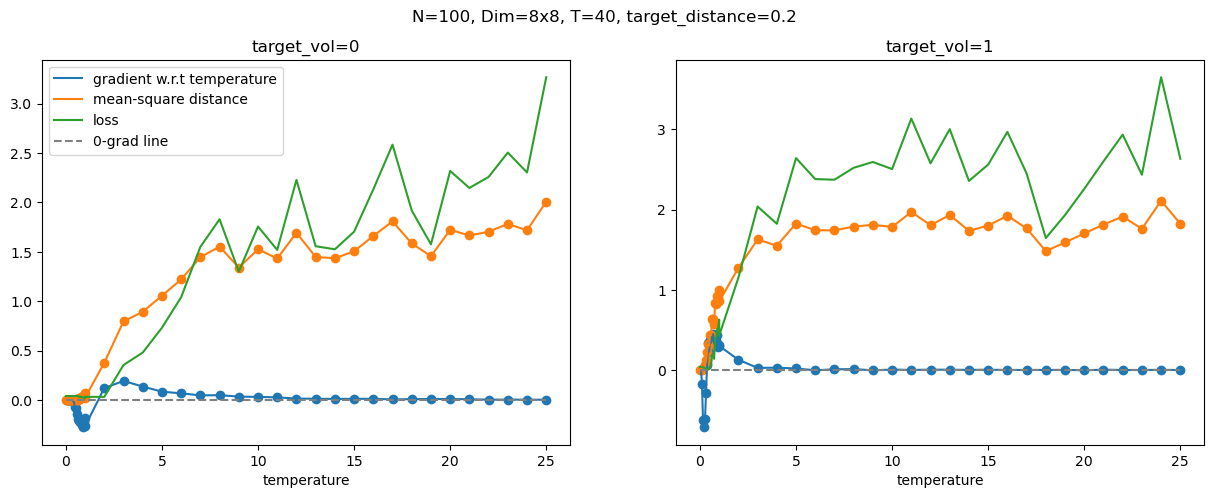

In [19]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.2")
plt.show()


target_vol = 0, target_dist = 1.2

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.2

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

target_vol = 1, target_distance = 1.2

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.2

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

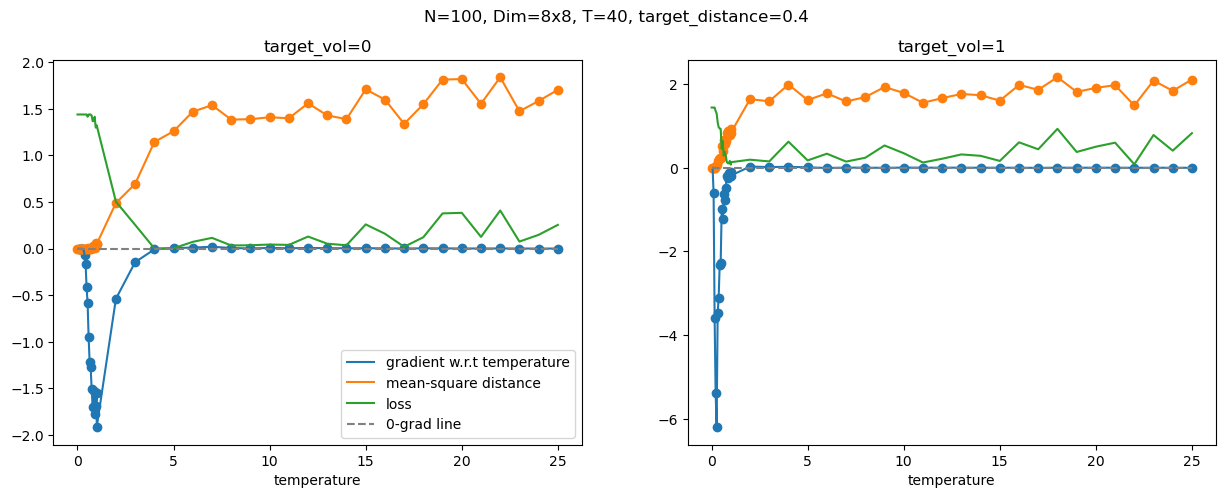

In [22]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.4")
plt.show()


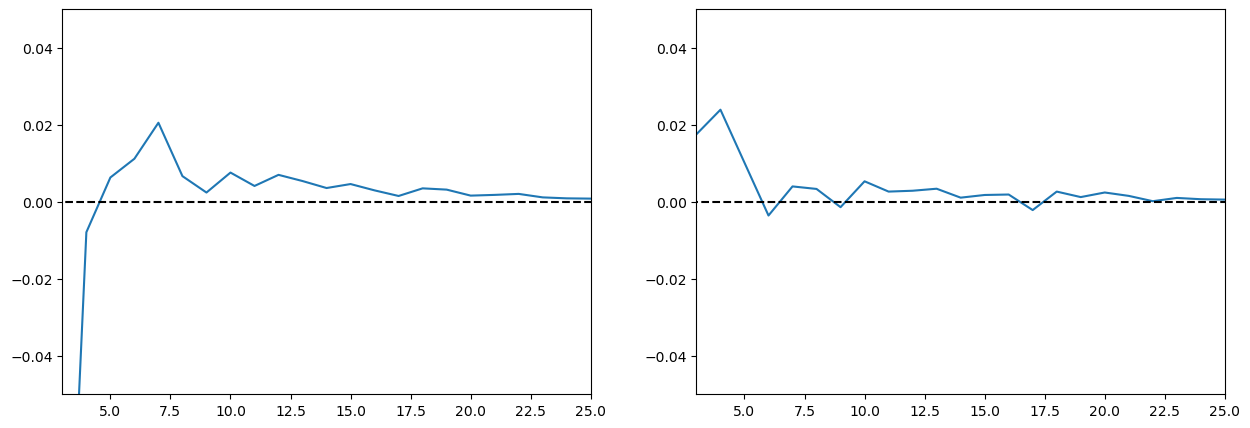

In [23]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(temps.cpu(), grads_v0)
axs[0].hlines([0.], xmin=0, xmax=25, linestyles="dashed", colors=["black"])
axs[0].set(ylim=(-0.05, 0.05), xlim=(3,25))

axs[1].plot(temps.cpu(), grads_v1)
axs[1].hlines([0.], xmin=0, xmax=25, linestyles="dashed", colors=["black"])
axs[1].set(ylim=(-0.05,0.05), xlim=(3,25))

plt.show()

## using a sim time of 100 instead breaks down the gradients

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.2

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=100, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.2

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=100, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

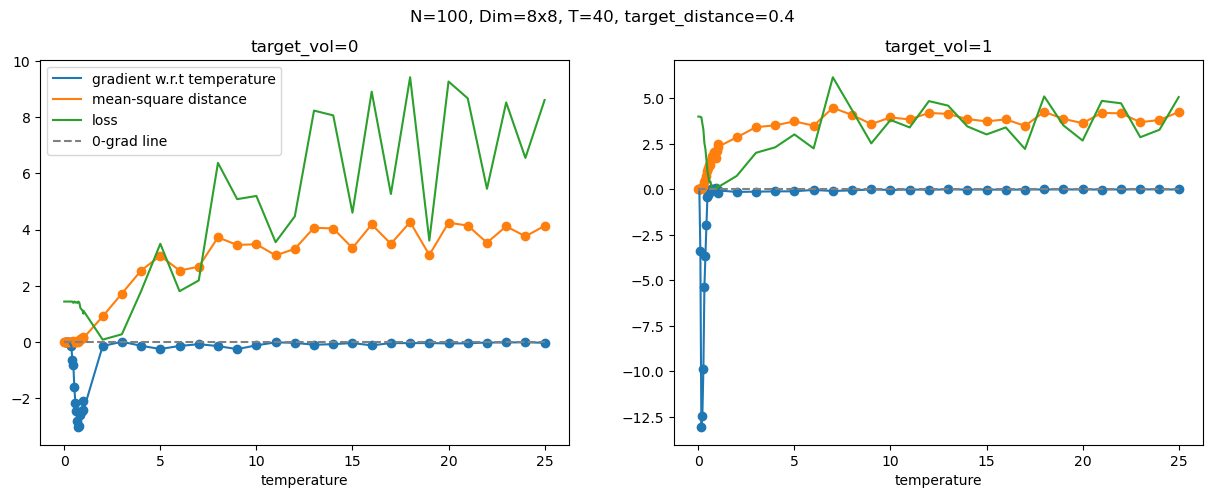

In [30]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.4")
plt.show()


What if we use regularization?

In [32]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float, num_steps:int, target_distance:float, lam: float):
    for i in tqdm(range(num_steps)):
        batch = MCS(batch, target_vol, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    print(f"temperature: {temperature}, mean distance: {mean_distance}")
    loss = (mean_distance - target_distance)**2 + lam * temperature**2
    grad = t.autograd.grad(loss, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, mean_distance, loss

lam = 0.001

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.2
lam = 0.001

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=100, target_distance=target_distance, lam=lam)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.2
lam = 0.001

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=100, target_distance=target_distance, lam=lam)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

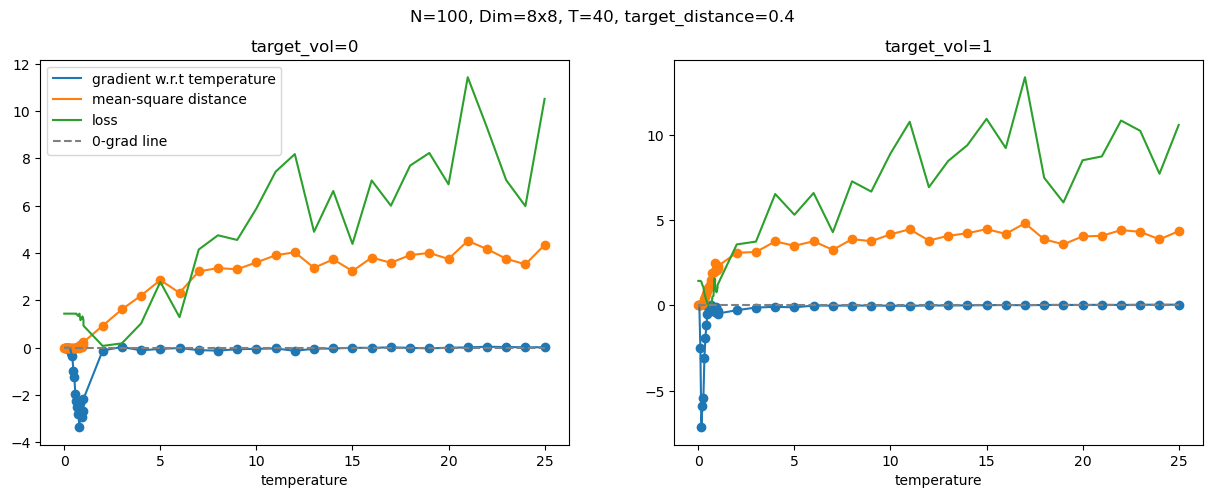

In [36]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.4")
plt.show()


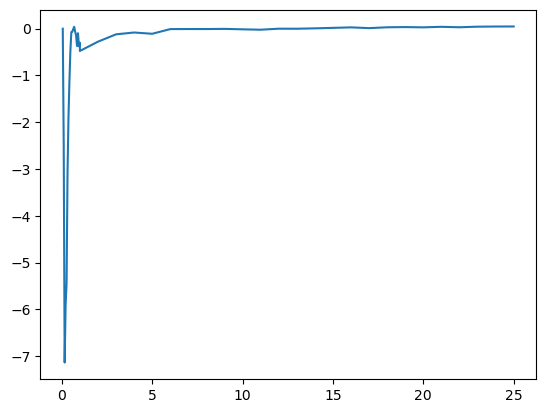

In [37]:
plt.plot(temps.cpu(),grads_v1)

lam = 0.01

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.2
lam = 0.01

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=100, target_distance=target_distance, lam=lam)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.2
lam = 0.01

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=100, target_distance=target_distance, lam=lam)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

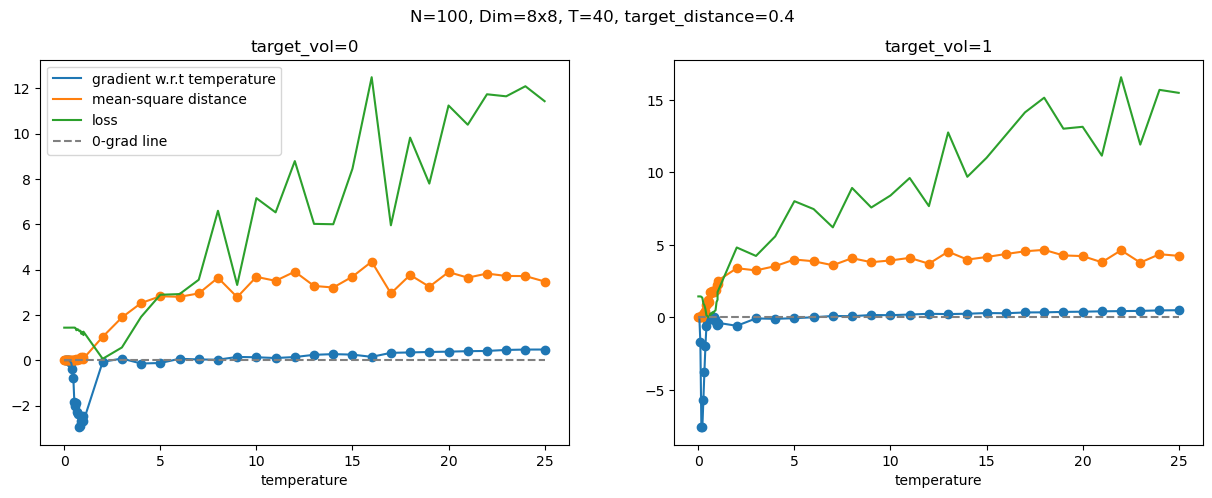

In [40]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.4")
plt.show()


lam = 0.05

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.2
lam = 0.05

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=100, target_distance=target_distance, lam=lam)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.2
lam = 0.05

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=100, target_distance=target_distance, lam=lam)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

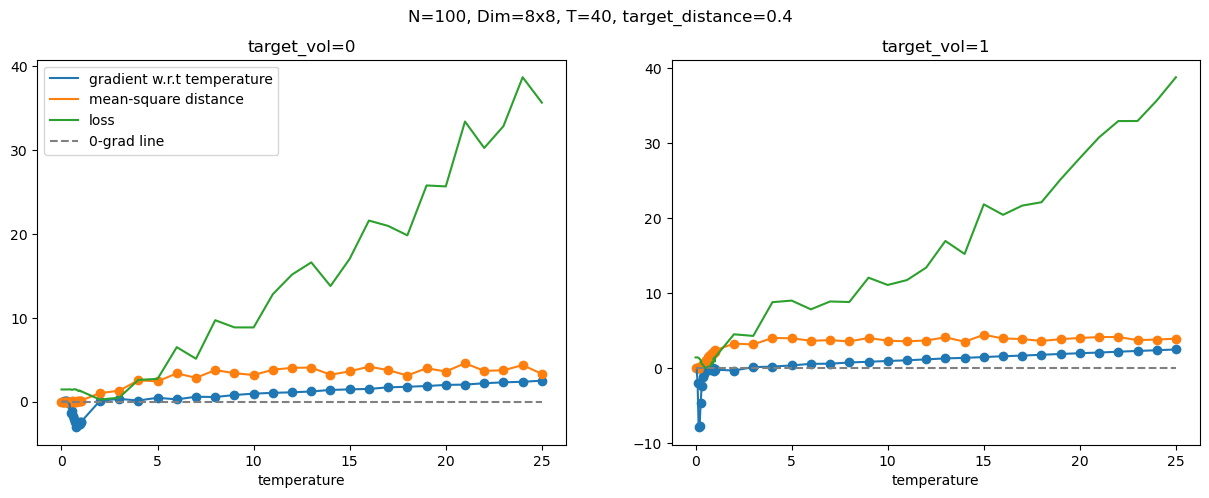

In [43]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.4")
plt.show()


lam = 0.1

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.2
lam = 0.1

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=100, target_distance=target_distance, lam=lam)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.2
lam = 0.1

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=100, target_distance=target_distance, lam=lam)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

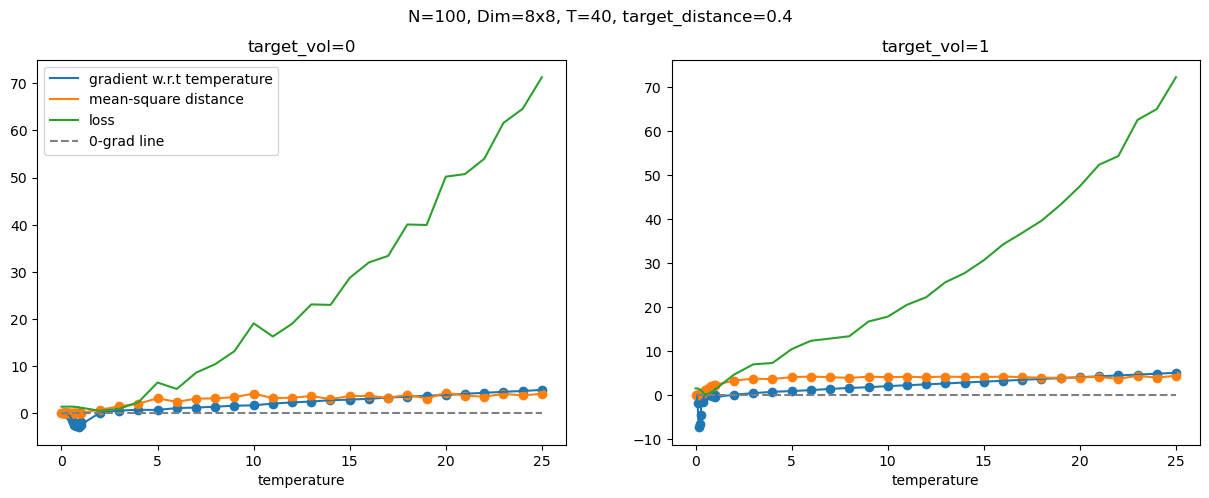

In [46]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.4")
plt.show()


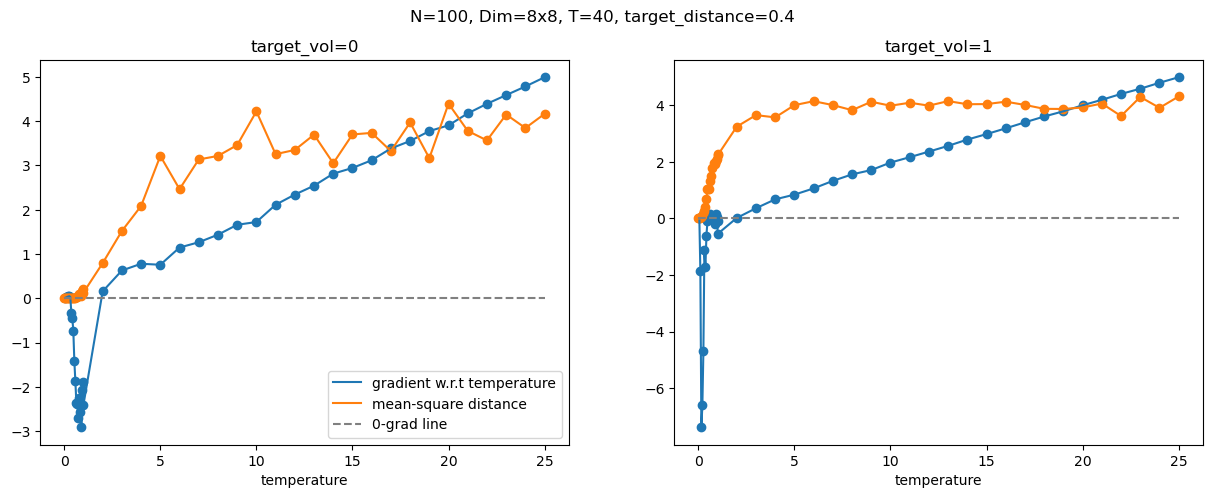

In [47]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.4")
plt.show()
